In [1]:
#auxiliary functions
library(TableHC)
library(ggplot2)

library(readr)
library(dplyr)
library(tidytext)

library(tidyverse)
library(data.table)
library(latex2exp)
library(readtext)

Warning message:
“package ‘TableHC’ was built under R version 3.5.2”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following object is masked from ‘package:purrr’:

    transpose

The following objects are masked from ‘package:dplyr’:

    between, first, last

Warning message:
“package ‘readtext’ was built under R version 3.5.2”

<H1>Within-Corpus Coefficient of Variance</H1>

Run R file
<pre>
  var_analysis.R
</pre>
to generate files:
<pre>
  df0_PAN2019_DTC.csv
  df1_PAN2019_DTC.csv
</pre>



In [2]:
# read results of obtained by testing 990 document-corpus pair

dir = "./"
df0 = fread(paste(dir,"df0_PAN2019_DTC.csv", sep = '/') )
df1 = fread(paste(dir,"df1_PAN2019_DTC.csv", sep = '/') )

dataset_name = "PAN2019_DTC"
vocab_size = 2000

df0 <- df0[,2:ncol(df0)]
df1 <- df1[,2:ncol(df1)]

df1 <- df1 %>% mutate(type = 'discordant')
df0 <- df0 %>% mutate(type = 'concordant')

<H2> Use `pairs-plot' to uncover stylized relationship</H2>
(we are interested in the relation between nstd = std/mu to rank)


Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


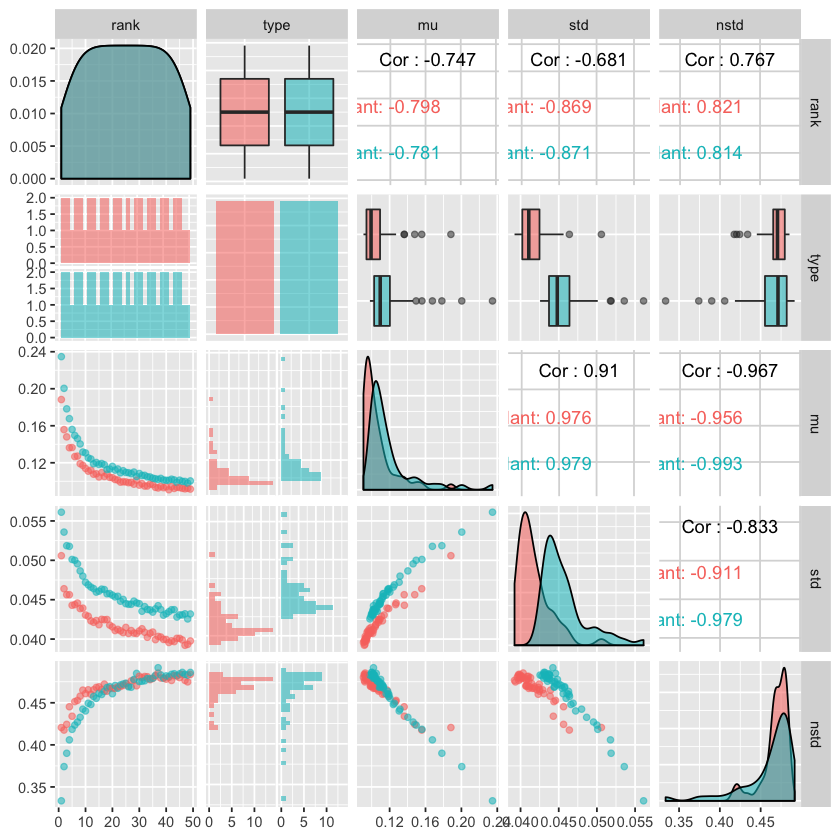

In [3]:
#average over df1 and df0
top_rank = 50 # only consider top_rank P-values

df.av <- rbind(df0, df1) %>%
        select(z,mu,p,std, rank, type, z_p, n_th, evar, class) %>% 
        remove_missing %>%
        group_by(class) %>%
#        mutate(std = std - mean(std)) %>%
        ungroup() %>%
        select(-class) %>%
        filter(rank < top_rank) %>%
        filter(abs(z) < 50) %>%  #remove words with extremely large z-score
        group_by(rank, type) %>% summarise(
                       nstd = mean(std/mu),
                       mu = mean(mu),
                       p = mean(p),
                       std = mean(std),
                       n_th = mean(n_th),
                       z = mean(z),
                      ) %>%
        ungroup()

library(GGally)
p <- ggpairs(df.av %>% select(rank, type, mu, std, nstd), aes(colour = type, alpha = 0.2))
print(p)


<H2>Relation between rank of P-values and coefficient of variance (std/mu)</H2>

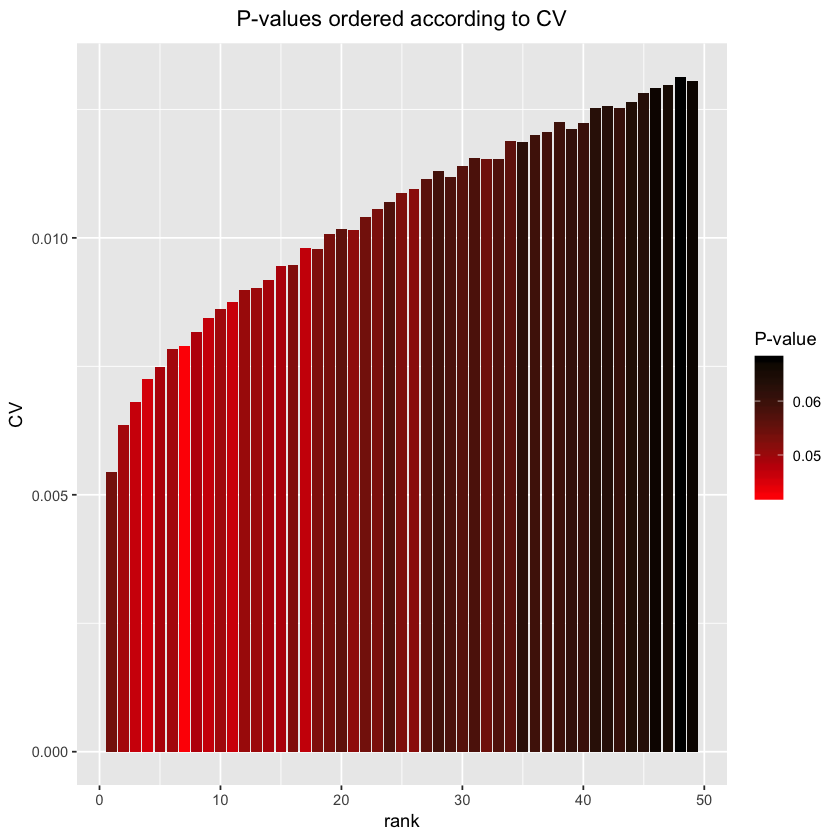

In [5]:
path_to_plots = "/Users/kipnisal/Dropbox/Apps//Overleaf/Authorship attribution using Higher Criticism (copy)/Figs/"
#path_to_plots = ""


# order by nstd
dfA <- rbind(df0, df1) %>%
        select(z,mu,p,std, rank, type, z_p, n_th, class, evar) %>% 
        mutate(nstd = std^2 / mu) %>%
        filter(abs(z) < 10) %>% #remove words with extremely large z-score
        group_by(class) %>% 
        arrange(std) %>%
        mutate(std_rank = order(std)) %>%
        ungroup() %>% remove_missing 
#        
dfA.av <- dfA %>%
        filter(std_rank < top_rank) %>%
        group_by(std_rank) %>% summarise(nstd = mean(nstd),
                                        std = mean(std),
                                           n_th = mean(n_th),
                                               p = mean(p),
                                          ) %>%
        ungroup()

dfA.av %>% ggplot(aes(x = std_rank , y = nstd, fill = p)) +
        geom_col() + 
        scale_fill_gradient(low = 'red', high = 'black', name = 'P-value') +
        ylab(TeX('$\\mathrm{CV}$'))  + xlab(TeX('rank')) +
        ggtitle(TeX("P-values ordered according to $\\mathrm{CV}$")) +
        theme(plot.title = element_text(hjust = 0.5)) +
        ggsave(paste(path_to_plots,"ordered_nstd_avg_",dataset_name,'_',vocab_size,"_words.png", sep = ''),
                            height = 3 , width = 5)


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


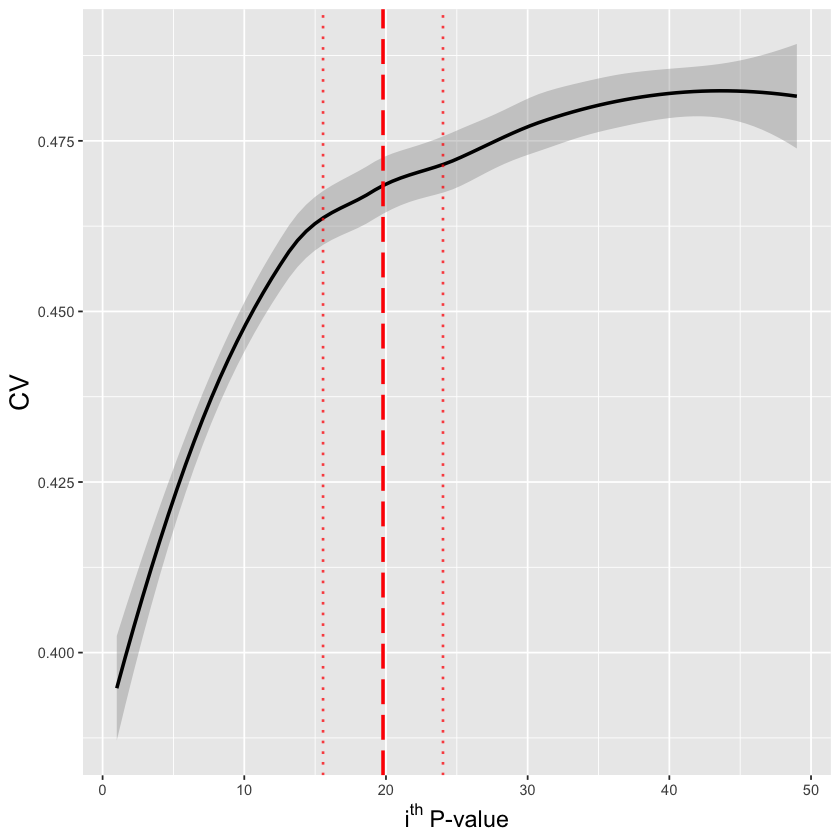

In [6]:
path_to_plots = "/Users/kipnisal/Dropbox/Apps/Overleaf/Authorship Attribution using Higher Criticism (Copy)/Figs/"
path_to_plots = ""

n_th = mean(df.av$n_th)
n_se = sqrt(var(df.av$n_th))

df.av %>% ggplot(aes(x = rank , y = nstd , fill = p)) +
        #geom_col(alpha = 0.75) +
        geom_smooth(color="black") +
        #geom_smooth(aes(y = dstd, color = 'std'), linetype="dashed") +        
        xlab(TeX('$i^{\\mathrm th}$ P-value')) +
        ylab(TeX('$\\mathrm{CV}$')) +
        geom_vline(xintercept = c(n_th-1.64*n_se,n_th+1.64*n_se), alpha = 0.75,
                   linetype="dotted", color = 'red', size = 0.75) +
        geom_vline(xintercept = n_th, alpha = 1, color = 'red', linetype="longdash", size = 1) +
        theme(legend.title = element_blank(), legend.position = "top",
              plot.title = element_text(hjust = 0.5, size=16), 
              legend.spacing.x = unit(0.25, 'cm'),
            legend.text=element_text(size=16),
              axis.title.x = element_text(size = 14),
              axis.title.y = element_text(size = 16)
             ) +
        #ggtitle(TeX("$\\mathrm{CV}$ vs P-value (average)"))
        ggsave(paste(path_to_plots,"nstd_vs_rank_avg_",dataset_name,'_',vocab_size,"_words.png", sep = ''),
              height = 3.5 , width = 5)


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


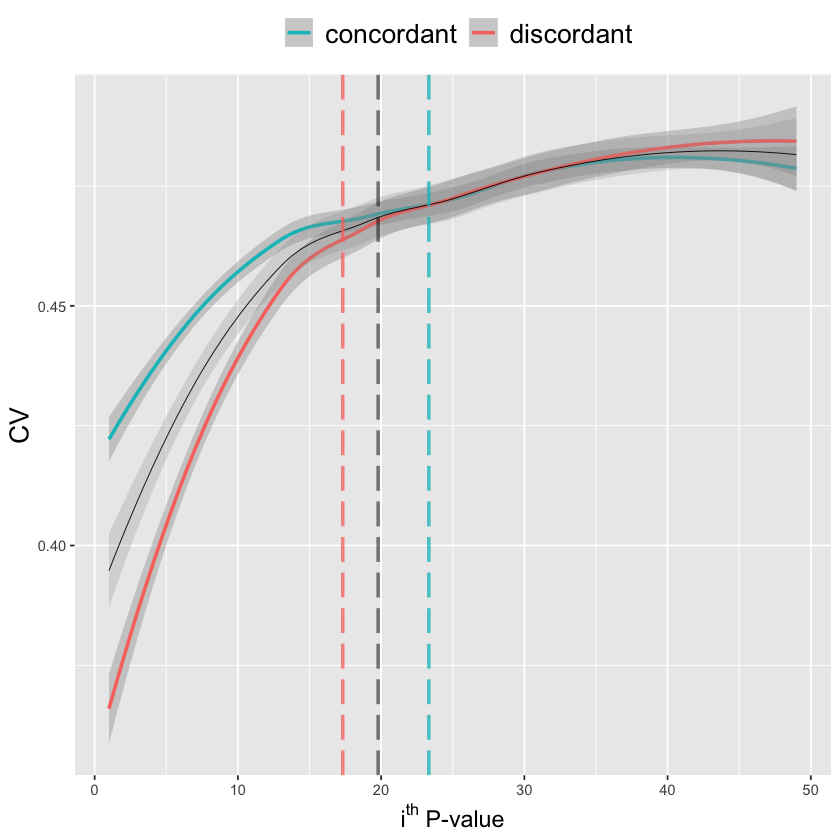

In [7]:
path_to_plots = "/Users/kipnisal/Dropbox/Apps/Overleaf/Authorship Attribution using Higher Criticism (Copy)/Figs/"
path_to_plots = ""

n_th = mean(df.av$n_th)
n_se = sqrt(var(df.av$n_th))

n_se1 = sqrt(var(df1$n_th))
n_mean1 = mean(df1$n_th)

n_se0 = sqrt(var(df0$n_th))
n_mean0 = mean(df0$n_th)


df.av %>% ggplot(aes(x = rank , y = nstd, color = type, label = rank)) +
            scale_color_manual(values = c('#00BFC4','#F8766D')) +
        theme(legend.title = element_blank(), legend.position = "top",
              plot.title = element_text(hjust = 0.5, size=16), 
              legend.spacing.x = unit(0.25, 'cm'),
            legend.text=element_text(size=16),
              axis.title.x = element_text(size = 14),
              axis.title.y = element_text(size = 16)
             ) +
        geom_smooth() + geom_smooth(aes(x = rank, y = nstd, color = 'average'),
                                    color = 'black', alpha = 0.25, size = 0.25) + 
        geom_vline(xintercept = n_th, alpha = 0.5, color = 'black',
                                   linetype="longdash", size = 1) +
        geom_vline(xintercept = c(n_mean0, n_mean1), alpha = 0.75, size = 1,
                   linetype="longdash", color = c('#F8766D','#00BFC4')) +
        #geom_vline(xintercept = c(n_th-1.64*n_se,n_th+1.64*n_se), alpha = 0.25,
        #           linetype="dashed", color = 'blue', size = 0.5) +
        #geom_vline(xintercept = c(n_mean0-1.64*n_se0, n_mean0+1.64*n_se0), alpha = 0.75,
        #           linetype="dotted", color = '#00BFC4', size = 1) +
        #geom_vline(xintercept = c(n_mean1-1.64*n_se1, n_mean1+1.64*n_se1), alpha = 0.75,
        #           linetype="dotted", color = '#F8766D', size = 1) +
        #scale_color_discrete(labels = c("between", "within", 'average'))
         xlab(TeX('$i^{\\mathrm th}$ P-value')) +
        ylab(TeX('$\\mathrm{CV}$')) +
        ggsave(paste(path_to_plots,"nstd_vs_rank_bw_",dataset_name,'_w',vocab_size,".png", sep = ''),
                            height = 3.5 , width = 5)

